# Using a feature representation learned for signature images

This notebook contains code to pre-process signature images and to obtain feature-vectors using the learned feature representation on the ICFHR 2010 Dataset

In [1]:
import numpy as np
import cv2
# Functions to load and pre-process the images:
from scipy.misc import imread, imsave
from preprocess.normalize import normalize_image, resize_image, crop_center, preprocess_signature

# Functions to load the CNN model
import signet
from cnn_model import CNNModel

# Functions for plotting:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'
resize_dim = (900,700)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


## Pre-processing a single image

In [15]:
original = cv2.imread('signatures/R1.png',0)
original = cv2.resize(original,resize_dim)


In [16]:
# Manually normalizing the image following the steps provided in the paper.
# These steps are also implemented in preprocess.normalize.preprocess_signature

normalized = 255 - normalize_image(original, size=(952, 1360))
resized = resize_image(normalized, (170, 242))
cropped = crop_center(resized, (150,220))


Text(0.5,1,'Cropped center of the image')

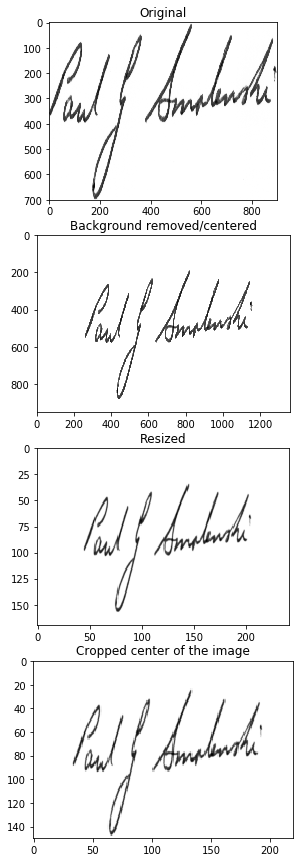

In [17]:
# Visualizing the intermediate steps

f, ax = plt.subplots(4,1, figsize=(6,15))
ax[0].imshow(original, cmap='Greys_r')
ax[1].imshow(normalized)
ax[2].imshow(resized)
ax[3].imshow(cropped)

ax[0].set_title('Original')
ax[1].set_title('Background removed/centered')
ax[2].set_title('Resized')
ax[3].set_title('Cropped center of the image')

## Processing multiple images and obtaining feature vectors

In [2]:
user1_gen  = [cv2.resize(cv2.imread('signatures/R%d.png' % i,0),resize_dim) for i in  [1,2]]
user1_forg  = [cv2.resize(cv2.imread('signatures/Q%d.png' % i,0),resize_dim) for i in  [1,2]]

canvas_size = (952, 1360)

processed_user1_gen = np.array([preprocess_signature(sig, canvas_size) for sig in user1_gen])
processed_user1_forg = np.array([preprocess_signature(sig, canvas_size) for sig in user1_forg])

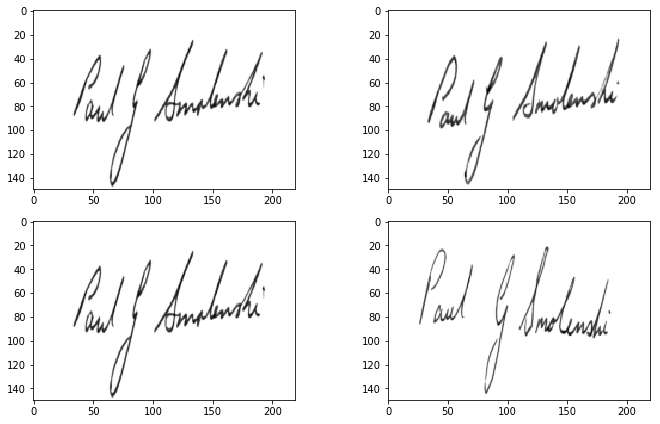

In [16]:
# Shows pre-processed samples of the two users

f, ax = (plt.subplots(2,2, figsize=(10,6)))
f.tight_layout()
ax[0,0].imshow(processed_user1_gen[0])
ax[0,1].imshow(processed_user1_gen[1])
#ax[0,0].set_title('Pair of similar (genuine) signatures - labelled as 1')
#ax[1,0].set_title('Pair of dissimilar (genuine and forged) signatures - labelled as 0')
ax[1,0].imshow(processed_user1_gen[0])
ax[1,1].imshow(processed_user1_forg[0])


### Using the CNN to obtain the feature representations

In [18]:
# Path to the learned weights
model_weight_path = 'models/signet.pkl'

In [19]:
# Instantiate the model
model = CNNModel(signet, model_weight_path)

In [20]:
# Obtain the features. Note that you can process multiple images at the same time

user1_gen_features = model.get_feature_vector_multiple(processed_user1_gen, layer='fc2')
user1_forg_features = model.get_feature_vector_multiple(processed_user1_forg, layer='fc2')

c:\python27\lib\site-packages\theano\tensor\signal\pool.py:557: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  yk[[region_slices[i][r[i]] for i in xrange(nd)]])


### Inspecting the learned features

The feature vectors have size 2048:

In [8]:
user1_gen_features.shape

(2L, 2048L)

In [21]:
print('Euclidean distance between signatures from different users')
print(np.linalg.norm(user1_gen_features[0] - user1_forg_features[0]))
#print(np.linalg.norm(user1_forg_features[0] - user1_forg_features[1]))

Euclidean distance between signatures from different users
18.865117348049413


In [10]:
print('Euclidean distance between signatures from different users')

dists = [np.linalg.norm(u1 - u2) for u1 in user1_gen_features for u2 in user1_forg_features]
print(dists)

Euclidean distance between signatures from different users
[18.865117348049413, 19.827421890820315, 16.850261150382526, 17.28882745260062]


## Visualising Learned Features

#### Genuine - Genuine Plot

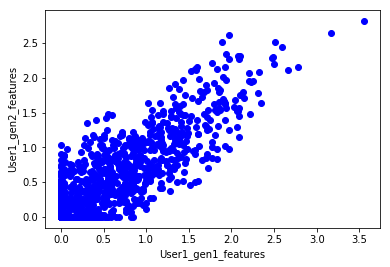

In [11]:
plt.scatter(user1_gen_features[0],user1_gen_features[1],c='blue')
plt.xlabel('User1_gen1_features')
plt.ylabel('User1_gen2_features')
plt.savefig('Genuine_scatter.png')

#### Genuine - Forge Plot

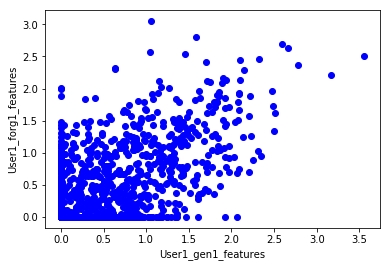

In [13]:
plt.scatter(user1_gen_features[0],user1_forg_features[0],c='blue')
plt.xlabel('User1_gen1_features')
plt.ylabel('User1_forg1_features')
plt.savefig('Forge_scatter.png')

#### Genuine - Forge Plot

Text(0,0.5,'User1_forg2_features')

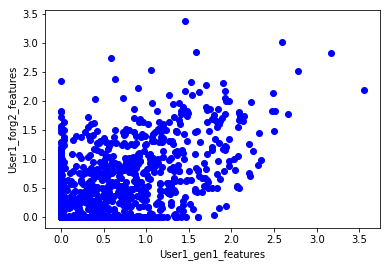

In [14]:
plt.scatter(user1_gen_features[0],user1_forg_features[1],c='blue')
plt.xlabel('User1_gen1_features')
plt.ylabel('User1_forg2_features')

#### Genuine - Forge Plot

Text(0,0.5,'User1_forg1_features')

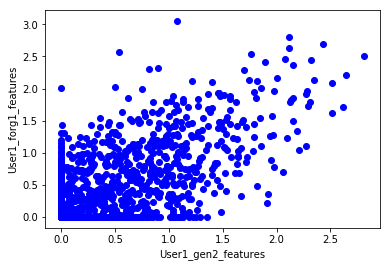

In [15]:
plt.scatter(user1_gen_features[1],user1_forg_features[0],c='blue')
plt.xlabel('User1_gen2_features')
plt.ylabel('User1_forg1_features')

#### Genuine - Forge Plot

Text(0,0.5,'User1_forg2_features')

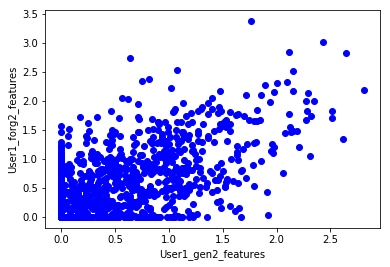

In [16]:
plt.scatter(user1_gen_features[1],user1_forg_features[1],c='blue')
plt.xlabel('User1_gen2_features')
plt.ylabel('User1_forg2_features')